In [5]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
from torch.nn.modules import transformer
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset,DataLoader
import numpy as np
import torch.optim as optim
from torchvision import transforms
import pandas as pd
import os
import argparse
from models import DeepConvNetELU, DeepConvNetReLU, DeepConvNetLeakyReLU

In [6]:

def read_bci_data():
    S4b_train = np.load('S4b_train.npz')
    X11b_train = np.load('X11b_train.npz')
    S4b_test = np.load('S4b_test.npz')
    X11b_test = np.load('X11b_test.npz')

    train_data = np.concatenate((S4b_train['signal'], X11b_train['signal']), axis=0)
    train_label = np.concatenate((S4b_train['label'], X11b_train['label']), axis=0)
    test_data = np.concatenate((S4b_test['signal'], X11b_test['signal']), axis=0)
    test_label = np.concatenate((S4b_test['label'], X11b_test['label']), axis=0)


    train_label = train_label - 1
    test_label = test_label -1
    train_data = np.transpose(np.expand_dims(train_data, axis=1), (0, 1, 3, 2))
    test_data = np.transpose(np.expand_dims(test_data, axis=1), (0, 1, 3, 2))
   

    mask = np.where(np.isnan(train_data))
    train_data[mask] = np.nanmean(train_data)

    mask = np.where(np.isnan(test_data))
    test_data[mask] = np.nanmean(test_data)

   

    return train_data, train_label, test_data, test_label

def testing(x_test,y_test,model,device):
    model.eval()
    with torch.no_grad():
        model.cuda(0)
        n = x_test.shape[0]

        x_test = x_test.astype("float32")
        y_test = y_test.astype("float32").reshape(y_test.shape[0],)

        x_test, y_test = Variable(torch.from_numpy(x_test)),Variable(torch.from_numpy(y_test))
        x_test,y_test = x_test.to(device),y_test.to(device)
        y_pred_test = model(x_test)
        correct = (torch.max(y_pred_test,1)[1]==y_test).sum().item()
        # print("testing accuracy:",correct/n)
    return correct/n


In [7]:
train_data, train_label, test_data, test_label = read_bci_data()

n = train_data.shape[0]
# epochs = 3000

device = torch.device("cuda:0")

train_data = train_data.astype("float32")
train_label = train_label.astype("float32").reshape(train_label.shape[0],)

# train_data.shape = (1080,1,2,750)
# train_label.shape = (1080,)

x, y = Variable(torch.from_numpy(train_data)),Variable(torch.from_numpy(train_label))
y=torch.tensor(y, dtype=torch.long)

C:\Users\Tree\AppData\Local\Temp\ipykernel_12432\1152162436.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=torch.tensor(y, dtype=torch.long)


In [8]:
epochs = 2000
lr = 1e-3
ELU_max_val_acc = 0
model = DeepConvNetELU()
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(),lr = lr, momentum = 0.9, weight_decay=1e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[600, 1200], gamma=0.5)

model.to(device)

loss_history = []
ELU_train_accuracy_history = []
ELU_test_accuracy_history = []
for epoch in range(epochs):
    # for idx,(data,target) in enumerate(loader):
    model.train()
    x,y = x.to(device),y.to(device)
    y_pred = model(x)

    loss = criterion(y_pred, y)
    train_loss = loss.item()
    loss_history.append(train_loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch%1==0:

        # correct= (y_pred.ge(0.5) == y).sum().item()
        n = y.shape[0]
        correct = (torch.max(y_pred,1)[1]==y).sum().item()
        train_accuracy = correct / n
        ELU_train_accuracy_history.append(train_accuracy)

        # print("epochs:",epoch,"loss:",loss.item(),"Accuracy:",(correct / n),"Learning rate:",scheduler.get_last_lr()[0])
        test_accuracy = testing(test_data,test_label,model,device)
        ELU_test_accuracy_history.append(test_accuracy)

        print("epochs:",epoch,"loss:",train_loss,"Training Accuracy:",train_accuracy,"Testing Accuracy:",test_accuracy,"Learning rate:",scheduler.get_last_lr()[0])
        
        if test_accuracy > ELU_max_val_acc:
            ELU_max_val_acc = test_accuracy

print("Max accuracy:",ELU_max_val_acc)

epochs: 0 loss: 0.795761227607727 Training Accuracy: 0.5101851851851852 Testing Accuracy: 0.5 Learning rate: 0.001
epochs: 1 loss: 37.54118728637695 Training Accuracy: 0.5 Testing Accuracy: 0.5 Learning rate: 0.001
epochs: 2 loss: 18.321670532226562 Training Accuracy: 0.5 Testing Accuracy: 0.5 Learning rate: 0.001
epochs: 3 loss: 1.8311227560043335 Training Accuracy: 0.5657407407407408 Testing Accuracy: 0.5481481481481482 Learning rate: 0.001
epochs: 4 loss: 12.865518569946289 Training Accuracy: 0.5064814814814815 Testing Accuracy: 0.512962962962963 Learning rate: 0.001
epochs: 5 loss: 15.64555835723877 Training Accuracy: 0.5055555555555555 Testing Accuracy: 0.5055555555555555 Learning rate: 0.001
epochs: 6 loss: 11.359976768493652 Training Accuracy: 0.5157407407407407 Testing Accuracy: 0.5 Learning rate: 0.001
epochs: 7 loss: 4.976504802703857 Training Accuracy: 0.5388888888888889 Testing Accuracy: 0.5453703703703704 Learning rate: 0.001
epochs: 8 loss: 5.174019813537598 Training Accu

In [9]:
epochs = 2000
lr = 1e-3
ReLU_max_val_acc = 0
model = DeepConvNetReLU()
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(),lr = lr, momentum = 0.9, weight_decay=1e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[600, 1200], gamma=0.5)

model.to(device)

loss_history = []
ReLU_train_accuracy_history = []
ReLU_test_accuracy_history = []
for epoch in range(epochs):
    # for idx,(data,target) in enumerate(loader):
    model.train()
    x,y = x.to(device),y.to(device)
    y_pred = model(x)

    loss = criterion(y_pred, y)
    train_loss = loss.item()
    loss_history.append(train_loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch%1==0:

        # correct= (y_pred.ge(0.5) == y).sum().item()
        n = y.shape[0]
        correct = (torch.max(y_pred,1)[1]==y).sum().item()
        train_accuracy = correct / n
        ReLU_train_accuracy_history.append(train_accuracy)

        # print("epochs:",epoch,"loss:",loss.item(),"Accuracy:",(correct / n),"Learning rate:",scheduler.get_last_lr()[0])
        test_accuracy = testing(test_data,test_label,model,device)
        ReLU_test_accuracy_history.append(test_accuracy)

        print("epochs:",epoch,"loss:",train_loss,"Training Accuracy:",train_accuracy,"Testing Accuracy:",test_accuracy,"Learning rate:",scheduler.get_last_lr()[0])
        
        if test_accuracy > ReLU_max_val_acc:
            ReLU_max_val_acc = test_accuracy

print("Max accuracy:",ReLU_max_val_acc)

epochs: 0 loss: 0.7864772081375122 Training Accuracy: 0.5064814814814815 Testing Accuracy: 0.5 Learning rate: 0.001
epochs: 1 loss: 43.503971099853516 Training Accuracy: 0.5 Testing Accuracy: 0.5 Learning rate: 0.001
epochs: 2 loss: 26.51297378540039 Training Accuracy: 0.5 Testing Accuracy: 0.5 Learning rate: 0.001
epochs: 3 loss: 7.0481462478637695 Training Accuracy: 0.5 Testing Accuracy: 0.5055555555555555 Learning rate: 0.001
epochs: 4 loss: 12.286775588989258 Training Accuracy: 0.5027777777777778 Testing Accuracy: 0.5 Learning rate: 0.001
epochs: 5 loss: 20.509296417236328 Training Accuracy: 0.5018518518518519 Testing Accuracy: 0.5 Learning rate: 0.001
epochs: 6 loss: 20.902061462402344 Training Accuracy: 0.5018518518518519 Testing Accuracy: 0.5037037037037037 Learning rate: 0.001
epochs: 7 loss: 17.09559440612793 Training Accuracy: 0.5027777777777778 Testing Accuracy: 0.5055555555555555 Learning rate: 0.001
epochs: 8 loss: 10.737605094909668 Training Accuracy: 0.5009259259259259 T

In [10]:
epochs = 2000
lr = 1e-3
LeakyReLU_max_val_acc = 0
model = DeepConvNetLeakyReLU()
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(),lr = lr, momentum = 0.9, weight_decay=1e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[600, 1200], gamma=0.5)

model.to(device)

loss_history = []
LeakyReLU_train_accuracy_history = []
LeakyReLU_test_accuracy_history = []
for epoch in range(epochs):
    # for idx,(data,target) in enumerate(loader):
    model.train()
    x,y = x.to(device),y.to(device)
    y_pred = model(x)

    loss = criterion(y_pred, y)
    train_loss = loss.item()
    loss_history.append(train_loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch%1==0:

        # correct= (y_pred.ge(0.5) == y).sum().item()
        n = y.shape[0]
        correct = (torch.max(y_pred,1)[1]==y).sum().item()
        train_accuracy = correct / n
        LeakyReLU_train_accuracy_history.append(train_accuracy)

        # print("epochs:",epoch,"loss:",loss.item(),"Accuracy:",(correct / n),"Learning rate:",scheduler.get_last_lr()[0])
        test_accuracy = testing(test_data,test_label,model,device)
        LeakyReLU_test_accuracy_history.append(test_accuracy)

        print("epochs:",epoch,"loss:",train_loss,"Training Accuracy:",train_accuracy,"Testing Accuracy:",test_accuracy,"Learning rate:",scheduler.get_last_lr()[0])
        
        if test_accuracy > LeakyReLU_max_val_acc:
            LeakyReLU_max_val_acc = test_accuracy

print("Max accuracy:",LeakyReLU_max_val_acc)


epochs: 0 loss: 0.8468872904777527 Training Accuracy: 0.5046296296296297 Testing Accuracy: 0.5 Learning rate: 0.001
epochs: 1 loss: 40.34977340698242 Training Accuracy: 0.5 Testing Accuracy: 0.5 Learning rate: 0.001
epochs: 2 loss: 23.173049926757812 Training Accuracy: 0.5 Testing Accuracy: 0.5 Learning rate: 0.001
epochs: 3 loss: 8.930676460266113 Training Accuracy: 0.5 Testing Accuracy: 0.4564814814814815 Learning rate: 0.001
epochs: 4 loss: 10.122200012207031 Training Accuracy: 0.5064814814814815 Testing Accuracy: 0.4962962962962963 Learning rate: 0.001
epochs: 5 loss: 17.456523895263672 Training Accuracy: 0.5018518518518519 Testing Accuracy: 0.49537037037037035 Learning rate: 0.001
epochs: 6 loss: 16.434402465820312 Training Accuracy: 0.49907407407407406 Testing Accuracy: 0.5083333333333333 Learning rate: 0.001
epochs: 7 loss: 9.853059768676758 Training Accuracy: 0.5138888888888888 Testing Accuracy: 0.4861111111111111 Learning rate: 0.001
epochs: 8 loss: 4.54752779006958 Training A

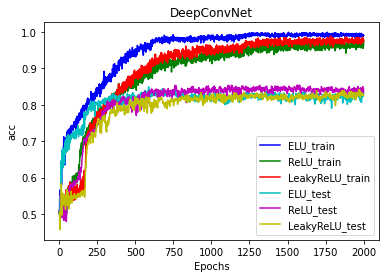

DeepConvNet with ELU       Max test Acc  = 0.8490740740740741
DeepConvNet with ReLU      Max test Acc  = 0.8537037037037037
DeepConvNet with LeakyReLU Max test Acc  = 0.8416666666666667


In [11]:
from matplotlib import pyplot as plt
#plot the training and validation accuracy and loss at each epoch

epochs = range(1, len(ELU_train_accuracy_history) + 1)
plt.plot(epochs, ELU_train_accuracy_history, label='ELU_train', color='b')
plt.plot(epochs, ReLU_train_accuracy_history, label='ReLU_train', color='g')
plt.plot(epochs, LeakyReLU_train_accuracy_history, label='LeakyReLU_train', color='r')
plt.plot(epochs, ELU_test_accuracy_history, label='ELU_test', color='c')
plt.plot(epochs, ReLU_test_accuracy_history, label='ReLU_test', color='m')
plt.plot(epochs, LeakyReLU_test_accuracy_history, label='LeakyReLU_test', color='y')
plt.title('DeepConvNet')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

print(f"{'DeepConvNet with ELU' : <27}{'Max test Acc' : <14}{'= '}{ELU_max_val_acc}")
print(f"{'DeepConvNet with ReLU' : <27}{'Max test Acc' : <14}{'= '}{ReLU_max_val_acc}")
print(f"{'DeepConvNet with LeakyReLU' : <27}{'Max test Acc' : <14}{'= '}{LeakyReLU_max_val_acc}")